In [2]:
#import sklearn as sk
from time import time
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
from datetime import datetime as date
import datetime as dt
from dateutil.relativedelta import*
import copy 
import sys
import math
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

import plotly.offline as pyo
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.graph_objs as go

import matplotlib.pyplot as plt

np.random.seed(42)


In [5]:
#loading a csv file with the data.
#each line in the table represenr a neighborhood per time period.
#זה המצב בו הקלאסטרים הם אלה שהצגתי עד 2021 כקלאבטרים הטובים!!!!!!!


data = pd.read_csv('dfall2.csv')

print("data shape: ",data.shape)
####כאן אני אוסף את כל הפיצ'רים מסוג סטרינג והופך אותם לדאמיז כדי שאוכללהדביק אותם אחר כך בלי שיפריעו לי עם מילוי הערכים החסרים  


data.columns

categorials = data.groupby(['msoa11cd']).agg({
    'msoa11nm':'first', 'rgn16nm':'first', 'metro' :'first',
    'RUC':'first','lad11cd':'first','metru_function':'first'})
categorials_dumm = pd.concat([pd.get_dummies(categorials[col]) for col in ['metru_function','rgn16nm']], axis=1, keys=categorials.columns)

data.reset_index(inplace=True)
data=data.drop([ 'index',
              # '%New','%Old', '%Lees', '%Free', '%Other', '%D', '%F', '%S', '%T',
               'metru_function', 'lad11cd', 'RUC', 'metro', 'rgn16nm',
               'Ref_area_price',
                'Area Hectares',
                'All usual residents',
               'Density (number of persons per hectare)', 'White',
               'Mixed/multiple ethnic groups', 'Asian/Asian British',
               'Black/African/Caribbean/Black British', 'Other ethnic group',
               'Average number of rooms per household', 'Net annual income',
                'msoa11nm',
                #'Mean_Price',
                #'price_relative_to_ref_area'
               ],axis = 1)


print(data)

print(categorials_dumm)
data

data shape:  (172817, 31)
         msoa11cd                    Period     Mean_Price  \
0       E02000001  1995-01-01_to_1995-12-31  136515.410959   
1       E02000001  1996-01-01_to_1996-12-31  133545.416667   
2       E02000001  1997-01-01_to_1997-12-31  144947.164905   
3       E02000001  1998-01-01_to_1998-12-31  218880.148676   
4       E02000001  1999-01-01_to_1999-12-31  220803.749543   
...           ...                       ...            ...   
172812  W02000423  2014-01-01_to_2014-12-31  160314.033981   
172813  W02000423  2015-01-01_to_2015-12-31  153550.483092   
172814  W02000423  2016-01-01_to_2016-12-31  165481.070175   
172815  W02000423  2017-01-01_to_2017-12-31  164512.465116   
172816  W02000423  2018-01-01_to_2018-12-31  169361.728395   

        price_relative_to_ref_area  Transactions       %New        %Old  \
0                         1.492119           219  15.068493   84.931507   
1                         1.387072           408  37.009804   62.990196   
2   

,msoa11cd,Period,Mean_Price,price_relative_to_ref_area,Transactions,%New,%Old,%Lees,%Free,%Other,%D,%F,%S,%T
0,E02000001,1995-01-01_to_1995-12-31,136515.410959,1.492119,219,15.068493,84.931507,5.022831,94.977169,0.0,0.456621,92.694064,0.913242,5.936073
1,E02000001,1996-01-01_to_1996-12-31,133545.416667,1.387072,408,37.009804,62.990196,0.735294,99.264706,0.0,0.245098,98.774510,0.490196,0.490196
2,E02000001,1997-01-01_to_1997-12-31,144947.164905,1.320253,473,28.541226,71.458774,1.691332,98.308668,0.0,0.000000,96.194503,0.845666,2.959831
3,E02000001,1998-01-01_to_1998-12-31,218880.148676,1.742157,491,34.623218,65.376782,2.240326,97.759674,0.0,1.018330,97.148676,0.203666,1.629328
4,E02000001,1999-01-01_to_1999-12-31,220803.749543,1.550442,547,26.325411,73.674589,2.376600,97.623400,0.0,0.548446,96.892139,0.731261,1.828154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172812,W02000423,2014-01-01_to_2014-12-31,160314.033981,1.011460,206,13.106796,86.893204,16.504854,83.495146,0.0,0.000000,80.097087,0.485437,19.417476
172813,W02000423,2015-01-01_to_2015-12-31,153550.483092,0.931583,207,0.000000,100.000000,14.975845,85.024155,0.0,0.483092,82.608696,0.966184,15.942029
172814,W02000423,2016-01-01_to_2016-12-31,165481.070175,0.965241,171,0.000000,100.000000,16.959064,83.040936,0.0,0.000000,81.871345,1.754386,16.374269
172815,W02000423,2017-01-01_to_2017-12-31,164512.465116,0.916860,215,6.046512,93.953488,14.418605,85.581395,0.0,0.465116,84.186047,3.720930,11.627907


In [6]:


def dealing_with_nulls (data):    
    """in this part of the function I find out which time period in which
    neighbourhood is missing(probably becouse of zero transactions) and fill it with nulls
    but neighborhoods that hava no data at their firs yers are new neghborhoods
    so I leave it with nulls
    """
    couples = []
    periods = data.Period.unique()
    print(periods)
    neighborhoods = data.msoa11cd.unique()
#     periods = data.groupby('Period').agg({'Transactions': 'sum'}).index
#     neighborhoods = data.groupby('msoa11cd').agg({'Transactions': 'sum'}).index
    for i in neighborhoods:
        for j in periods:
            couples.append([i,j])    
    df1 = pd.DataFrame(couples,columns = ["msoa11cd","Period"])
    df = pd.merge(df1,data, left_on=['msoa11cd','Period'],right_on=['msoa11cd','Period'] ,how='left')
    """here I interpulating the missing data for each neighborhood sepperatly"""
    j=0
    for i in neighborhoods:
        if j==0:
            df2 = df[df['msoa11cd']==i]
            df2 = df2.interpolate()
        else:
            tempdf = df[df['msoa11cd']==i]
            tempdf = tempdf.interpolate()
            df2 = df2.append(tempdf,ignore_index = True)
        j=+1
    return df2
        
    

In [7]:
def make_T_periods_table (data, t):
    print("start make_T_periods_table")
    time_seriece = []
    #neighborhoods = data.groupby('msoa11cd').agg({'Transactions': 'sum'}).index
    neighborhoods = data.msoa11cd.unique()
    for neighborhood in neighborhoods:
        neighborhood_fd = data[data["msoa11cd"]==neighborhood]
        leng = len(neighborhood_fd)
        for i in range(leng-(t-1)):
            temp_df = neighborhood_fd[i:i+t]
#            ////////////////////////
             #period = temp_df.iloc[0]['Period'][:10]+"_to_"+temp_df.iloc[t-1]['Period'][-10:]  
            start =  pd.to_datetime(temp_df.iloc[0]['Period'][:10],format='%Y-%m-%d') 
            end =pd.to_datetime( temp_df.iloc[t-1]['Period'][-10:] ,format='%Y-%m-%d') 
#           ///////////////////////
            temp_df = temp_df.drop(["msoa11cd","Period"],axis = 1)
            temp_df = temp_df.to_numpy()
            temp_df = temp_df.reshape((1,-1))
            temp_df = temp_df.tolist()
            temp_df = [neighborhood,start,end]+temp_df[0]
            time_seriece.append(temp_df)
    time_seriece = pd.DataFrame(time_seriece)
    # מוחק את כל ה-NAN
    time_seriece = time_seriece.dropna()
    return(time_seriece)

In [8]:
data = dealing_with_nulls (data)
data


['1995-01-01_to_1995-12-31' '1996-01-01_to_1996-12-31'
 '1997-01-01_to_1997-12-31' '1998-01-01_to_1998-12-31'
 '1999-01-01_to_1999-12-31' '2000-01-01_to_2000-12-31'
 '2001-01-01_to_2001-12-31' '2002-01-01_to_2002-12-31'
 '2003-01-01_to_2003-12-31' '2004-01-01_to_2004-12-31'
 '2005-01-01_to_2005-12-31' '2006-01-01_to_2006-12-31'
 '2007-01-01_to_2007-12-31' '2008-01-01_to_2008-12-31'
 '2009-01-01_to_2009-12-31' '2010-01-01_to_2010-12-31'
 '2011-01-01_to_2011-12-31' '2012-01-01_to_2012-12-31'
 '2013-01-01_to_2013-12-31' '2014-01-01_to_2014-12-31'
 '2015-01-01_to_2015-12-31' '2016-01-01_to_2016-12-31'
 '2017-01-01_to_2017-12-31' '2018-01-01_to_2018-12-31']


,msoa11cd,Period,Mean_Price,price_relative_to_ref_area,Transactions,%New,%Old,%Lees,%Free,%Other,%D,%F,%S,%T
0,E02000001,1995-01-01_to_1995-12-31,136515.410959,1.492119,219.0,15.068493,84.931507,5.022831,94.977169,0.0,0.456621,92.694064,0.913242,5.936073
1,E02000001,1996-01-01_to_1996-12-31,133545.416667,1.387072,408.0,37.009804,62.990196,0.735294,99.264706,0.0,0.245098,98.774510,0.490196,0.490196
2,E02000001,1997-01-01_to_1997-12-31,144947.164905,1.320253,473.0,28.541226,71.458774,1.691332,98.308668,0.0,0.000000,96.194503,0.845666,2.959831
3,E02000001,1998-01-01_to_1998-12-31,218880.148676,1.742157,491.0,34.623218,65.376782,2.240326,97.759674,0.0,1.018330,97.148676,0.203666,1.629328
4,E02000001,1999-01-01_to_1999-12-31,220803.749543,1.550442,547.0,26.325411,73.674589,2.376600,97.623400,0.0,0.548446,96.892139,0.731261,1.828154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172819,W02000423,2014-01-01_to_2014-12-31,160314.033981,1.011460,206.0,13.106796,86.893204,16.504854,83.495146,0.0,0.000000,80.097087,0.485437,19.417476
172820,W02000423,2015-01-01_to_2015-12-31,153550.483092,0.931583,207.0,0.000000,100.000000,14.975845,85.024155,0.0,0.483092,82.608696,0.966184,15.942029
172821,W02000423,2016-01-01_to_2016-12-31,165481.070175,0.965241,171.0,0.000000,100.000000,16.959064,83.040936,0.0,0.000000,81.871345,1.754386,16.374269
172822,W02000423,2017-01-01_to_2017-12-31,164512.465116,0.916860,215.0,6.046512,93.953488,14.418605,85.581395,0.0,0.465116,84.186047,3.720930,11.627907


In [10]:

# #############################################################################
# Visualize the results on PCA-reduced data
def plotting_reduced_(to_k_means,init_centroids,K):
    print("enter to plotting function")
    reduced_data = PCA(n_components=2).fit_transform(to_k_means)
    #kmeans = KMeans(init=init_centroids, n_clusters=K)
    kmeans= KMeans(init='k-means++', n_clusters=K, n_init=10)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=0.5)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

['E02004616', 'E02004768', 'E02001074', 'E02004444', 'E02006697', 'E02000246', 'E02001648']
start make_T_periods_table
1
2
3
4


C:\Users\user\Miniconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning:

merging between different levels can give an unintended result (1 levels on the left, 2 on the right)



5


C:\Users\user\Miniconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning:

Explicit initial center position passed: performing only one init in k-means instead of n_init=10



finished kmeans  7


C:\Users\user\Miniconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\Miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1133: RuntimeWarning:

Explicit initial center position passed: performing only one init in k-means instead of n_init=10



sending to plotting function
enter to plotting function


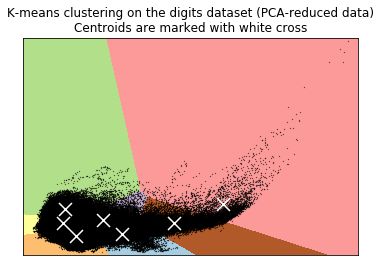

C:\Users\user\Miniconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



                0          1          2  labels_     dist_
0       E02000001 1995-01-01 1999-12-31        1  0.157325
1       E02000001 1996-01-01 2000-12-31        1  0.167202
2       E02000001 1997-01-01 2001-12-31        1  0.162810
3       E02000001 1998-01-01 2002-12-31        1  0.157050
4       E02000001 1999-01-01 2003-12-31        1  0.155121
...           ...        ...        ...      ...       ...
143890  W02000423 2010-01-01 2014-12-31        1  0.089196
143891  W02000423 2011-01-01 2015-12-31        1  0.090317
143892  W02000423 2012-01-01 2016-12-31        1  0.089558
143893  W02000423 2013-01-01 2017-12-31        1  0.087100
143894  W02000423 2014-01-01 2018-12-31        1  0.086998

[143895 rows x 5 columns]
start make_T_periods_table
1
2
3
4


C:\Users\user\Miniconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning:

merging between different levels can give an unintended result (1 levels on the left, 2 on the right)



5


C:\Users\user\Miniconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning:

Explicit initial center position passed: performing only one init in k-means instead of n_init=10



finished kmeans  7


C:\Users\user\Miniconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\Miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1133: RuntimeWarning:

Explicit initial center position passed: performing only one init in k-means instead of n_init=10



sending to plotting function
enter to plotting function


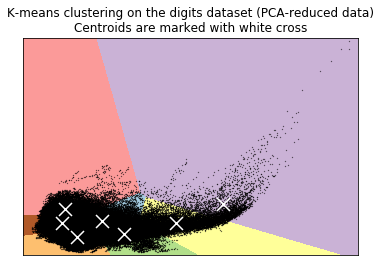

C:\Users\user\Miniconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



                0          1          2  labels_     dist_
0       E02000001 1995-01-01 2000-12-31        6  0.146849
1       E02000001 1996-01-01 2001-12-31        6  0.152276
2       E02000001 1997-01-01 2002-12-31        6  0.147991
3       E02000001 1998-01-01 2003-12-31        6  0.150016
4       E02000001 1999-01-01 2004-12-31        6  0.138148
...           ...        ...        ...      ...       ...
136695  W02000423 2009-01-01 2014-12-31        6  0.110383
136696  W02000423 2010-01-01 2015-12-31        6  0.080616
136697  W02000423 2011-01-01 2016-12-31        6  0.080760
136698  W02000423 2012-01-01 2017-12-31        6  0.079829
136699  W02000423 2013-01-01 2018-12-31        6  0.078047

[136700 rows x 5 columns]
start make_T_periods_table


KeyboardInterrupt: 

In [11]:
##############################33
K=7
results = pd.DataFrame(columns = [ 0,1 ,2,'labels_' ,'dist_'])
init_medoid_nei =categorials_dumm.sample(K,random_state=42).index.tolist()
print(init_medoid_nei)

######################

for t in range(5,10):  #t is the time range of neighborhood processess. some takes 5 years, and some 10
    time_seriece = make_T_periods_table (data,t)
    print("1")
    #כאן אני מכניס את הפיצ'רים הקטגוריאליים בצורת דאמיס שעשיתי בבלוק הראשון
    time_seriece_with_dummies = pd.merge(time_seriece,categorials_dumm,left_on=0, right_on='msoa11cd',how='left')
   # time_seriece_with_dummies =time_seriece#!!!!!!!!!!!!!!!!!!!!!!!!!!1למחוק ולשים את השורה למעלה
    # כאן אני מאתחל את הצנטרואידים לפי שכונות קבועות שנבחרו כמה שורות למעלה 
    print("2")
    init_centroids = time_seriece_with_dummies.groupby(0).first()
    print("3")
    init_centroids = init_centroids.reset_index()
    init_centroids = init_centroids[init_centroids[0].isin(init_medoid_nei)].index 
    print("4")
    to_k_means = scale(time_seriece_with_dummies.drop([0,1,2],axis = 1))
    #to_k_means = time_seriece_with_dummies.drop([0,1,2],axis = 1).to_numpy()
    init_centroids = to_k_means[init_centroids,:]
    print("5")

    #initializing the k-means with init_centroids
    kmeans = KMeans(n_clusters=K,init= init_centroids).fit(to_k_means)
    print("finished kmeans ",K)
    data_with_labels = time_seriece_with_dummies[[0,1,2]]
    data_with_labels['labels_']=kmeans.labels_
    alldistances = np.array(kmeans.fit_transform(to_k_means))
    print("sending to plotting function")
    plotting_reduced_(to_k_means,init_centroids,K)
    
    #כאן אני מחשב את המרחק בים כל נקודה לצנטרואיד הכי קרוב אליה, חלקי מספר המימדים, כדי לנרמל שייכות לקלאסטרים
    data_with_labels["dist_"] = np.min(alldistances, axis=1)/to_k_means.shape[1]
    results = results.append( data_with_labels, ignore_index=True)
    print(data_with_labels)
results = results.sort_values(by=[0,1])
#האוביקט "ריזולטס" הוא טבלא בה יש את הלייבלים של כל שכונה בתקופת זמן באורך משתנה
#ואת המרחק של כל שכונה בתקופת זמן מהצנטרואיד שלה
#ככה אני יכול לדעת מה ה"מובהקות" של כל שכונה לקלאסטר שלה
#ואם למשל לשכונה מסוימת בתקופה 1995-2000 יש מרחק קרוב יות מהקלאסטר של אותה שכונה בתקופה 1995-2003
#אני מניח שהתהליך שהיא עברה הוא תהליך של 5 שנים ולא 8 שנים
results

    
##############################    

In [ ]:
time_seriece_with_dummies[6].dtype
to_k_means.shape

In [ ]:
time_seriece

In [ ]:
data_with_labels

In [ ]:
to_k_means#.shape


In [ ]:
#results.to_csv('kmeans_results.csv')
results[2] = results[2]+dt.timedelta(days=1)

In [ ]:
results

In [ ]:

#מה שאני עושה כאן זה לבנות טבלא בה בכל שכונה, בכל תקופת זמן, אני מוצא את הקלאסטר, מתוך כל אלה שהשכונה בתקופה הזאת שייכת הליהם,
#שהכי קרוב אל מרכז הכלאסטר ומכריז הליו כ"קלאסטר המנצח של התקופה לשכונה.   
def create_final_model_table(results):
    final_model_teble = pd.DataFrame({'msoa11cd':pd.unique(results[0])})
    errors = pd.DataFrame({'msoa11cd':pd.unique(results[0])})
    print (final_model_teble)
    #יוצר רשימה של כל התאריכים 
    starting_date = results[1].min()
    end_date =  results[2].max()
    dates = np.unique(results[[1, 2]].values)


    for neighborhood in final_model_teble['msoa11cd']:
    #for neighborhood in pd.unique(results[0]):
        print("sterting neighborhood: ",neighborhood)
        temp_results = results[results[0]==neighborhood]
        for date in dates[:-1]:
            str_date=str(date)
            temp_diss = []
            temp_labless=[]
            for row in temp_results.iterrows():
                if (date>=row[1][1] and date<row[1][2]):
                    temp_diss.append(row[1]['dist_'])
                    temp_labless.append(row[1]['labels_'])
            if (len(temp_diss)>0):
                final_model_teble.at[final_model_teble['msoa11cd']==neighborhood,str_date]=temp_labless[temp_diss.index(min(temp_diss))]
                errors.at[errors['msoa11cd']==neighborhood,date]=temp_diss[temp_diss.index(min(temp_diss))]
    return(final_model_teble, errors)

            
final_K_means_table,errors = create_final_model_table(results)

In [ ]:

final_K_means_table

In [17]:
final_K_means_table= final_K_means_table.rename(columns=lambda s: s[:10])
final_K_means_table.to_csv('final_K_means_7__2018.csv')
#errors.to_csv('errorsfinal_K_means_7__relative_and_relative_price_full.csv')

In [95]:
final_K_means_table

,msoa11cd,1995-01-01,1996-01-01,1997-01-01,1998-01-01,1999-01-01,2000-01-01,2001-01-01,2002-01-01,2003-01-01,...,2009-01-01,2010-01-01,2011-01-01,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01
0,E02000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E02000002,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,E02000003,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,E02000004,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,E02000005,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,W02000419,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7191,W02000420,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
7192,W02000421,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7193,W02000422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
final_K_means_table = pd.read_csv('final_K_means_7_changes_only5.csv')
final_K_means_table.head(5)

In [ ]:
data.head(50)

In [98]:
table = data.pivot(index='msoa11cd',columns='Period',values='price_relative_to_ref_area')

table= table.rename(columns=lambda s: s[:10])

table

Period,1995-01-01,1996-01-01,1997-01-01,1998-01-01,1999-01-01,2000-01-01,2001-01-01,2002-01-01,2003-01-01,2004-01-01,...,2009-01-01,2010-01-01,2011-01-01,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01
msoa11cd,,,,,,,,,,,,,,,,,,,,,
E02000001,1.492119,1.387072,1.320253,1.742157,1.550442,1.426354,1.332307,1.210414,1.262790,1.243269,...,1.282845,1.373715,1.436013,1.320748,1.780588,1.724458,1.675480,1.512703,1.720281,2.526261
E02000002,0.630419,0.586031,0.675308,0.571691,0.525328,0.512599,0.511197,0.559655,0.651741,0.632123,...,0.569911,0.515171,0.537400,0.510251,0.470729,0.482840,0.505410,0.530823,0.548594,0.549690
E02000003,0.619323,0.611889,0.556465,0.558626,0.535332,0.528391,0.561421,0.606292,0.659158,0.670074,...,0.566199,0.578994,0.544134,0.525282,0.513540,0.506013,0.522914,0.529240,0.571717,0.546701
E02000004,0.662137,0.663479,0.658115,0.693185,0.658616,0.658537,0.583944,0.619084,0.661429,0.676942,...,0.593156,0.562649,0.550576,0.547524,0.522380,0.525509,0.561799,0.625736,0.606222,0.617799
E02000005,0.563145,0.510362,0.511487,0.503753,0.485497,0.483064,0.482472,0.536742,0.596797,0.627999,...,0.530240,0.497062,0.472593,0.442179,0.457615,0.502605,0.542861,0.600017,0.576005,0.543679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W02000419,0.889743,0.850781,0.822889,0.776466,0.801961,0.787758,0.787348,0.798244,0.851748,0.824225,...,0.672378,0.740837,0.737735,0.746276,0.807010,0.793036,0.818471,0.791491,0.781642,0.786348
W02000420,1.619929,1.736020,1.583901,1.678408,1.702485,1.658025,1.643145,1.729145,1.695722,1.627954,...,1.359930,1.499563,1.447905,1.519919,1.510579,1.576517,1.522549,1.627439,1.517100,1.663467
W02000421,1.209260,1.188534,1.240898,1.164605,1.145713,1.095364,1.241951,1.095354,1.175467,1.166168,...,1.230852,1.173042,1.310979,1.219466,1.273202,1.159073,1.211989,1.140618,1.138317,1.172369


In [50]:
def plot_lines(table,final_K_means_table):
    print("starting")
    #enable_plotly_in_cell()
    traces = []
    print("SHAPE",table.shape)
    for i in range(len(table)):
        trace = go.Scatter(
            #y = table.iloc[i].values.tolist(),
            y = table.iloc[i].where(final_K_means_table.iloc[i].values>=-7).values.tolist(),
            x = table.columns,
            line=dict
            (
                shape='linear',width=0.2, color='black' 
            ),
            mode = 'lines',
            name = i,
            opacity = 1,
        )
        trace0 = go.Scatter(
            #y = table.iloc[i].values.tolist(),
            y = table.iloc[i].where(final_K_means_table.iloc[i].values==0).values.tolist(),
            x = table.columns,
            line=dict
            (
                shape='linear',width=0.6, color='blue' 
            ),
            mode = 'lines',
            name = i,
            opacity = 1,
        )
        trace1 = go.Scatter(
            #y = table.iloc[i].values.tolist(),
            y = table.iloc[i].where(final_K_means_table.iloc[i].values==1).values.tolist(),
            x = table.columns,
            line=dict
            (
                shape='linear',width=0.6, color='orange' 
            ),
            mode = 'lines',
            name = i,
            opacity = 1,
        )
        
        trace2 = go.Scatter(
            #y = table.iloc[i].values.tolist(),
            y = table.iloc[i].where(final_K_means_table.iloc[i].values==2).values.tolist(),
            x = table.columns,
            line=dict
            (
                shape='linear',width=0.6, color='pink' 
            ),
            mode = 'lines',
            name = i,
            opacity = 1,
        )
        trace3 = go.Scatter(
            #y = table.iloc[i].values.tolist(),
            y = table.iloc[i].where(final_K_means_table.iloc[i].values==3).values.tolist(),
            x = table.columns,
            line=dict
            (
                shape='linear',width=0.6, color='green' 
            ),
            mode = 'lines',
            name = i,
            opacity = 1,
        )
        trace4 = go.Scatter(
            #y = table.iloc[i].values.tolist(),
            y = table.iloc[i].where(final_K_means_table.iloc[i].values==4).values.tolist(),
            x = table.columns,
            line=dict
            (
                shape='linear',width=0.6, color='brown' 
            ),
            mode = 'lines',
            name = i,
            opacity = 1,
        )
        trace5 = go.Scatter(
            #y = table.iloc[i].values.tolist(),
            y = table.iloc[i].where(final_K_means_table.iloc[i].values==5).values.tolist(),
            x = table.columns,
            line=dict
            (
                shape='linear',width=0.8, color='red' 
            ),
            mode = 'lines',
            name = i,
            opacity = 1,
        )
        trace6 = go.Scatter(
            #y = table.iloc[i].values.tolist(),
            y = table.iloc[i].where(final_K_means_table.iloc[i].values==6).values.tolist(),
            x = table.columns,
            line=dict
            (
                shape='linear',width=0.6, color='purple' 
            ),
            mode = 'lines',
            name = i,
            opacity = 1,
        )
                
                
        
#         tracelabel = go.Scatter(
#             y = final_K_means_table.iloc[i].values.tolist(),
#             x = final_K_means_table.columns,
#             line=dict
#             (
#                 shape='linear',width=0.6  
#             ),
#             mode = 'lines',
#             name = i,
#             opacity = 0.99,
#         )
        traces.append(trace)
        traces.append(trace0)
        traces.append(trace1)
        traces.append(trace2)
        traces.append(trace3)
        traces.append(trace4)
        traces.append(trace5)
      #  traces.append(trace6)
      #  traces.append(tracelabel)
      #  print("IIIIIIi",trace5)

    plotData = traces
    layout = go.Layout(title="relative_and real full data", autosize=False, width=2000, height=2000,)
    figure = go.Figure(data = plotData, layout=layout)
    iplot(figure)
    pyo.plot(figure)
    figure.write_image("fig1.png")
    print("END)")

    
    
# rand_table = table#.sample(n=100,random_state=9)
# rand_labels = final_K_means_table.drop(['Unnamed: 0','msoa11cd'],axis=1)
rand_table = table.sample(n=100,random_state=9)
rand_labels = final_K_means_table.sample(n=100,random_state=9).drop(['Unnamed: 0','msoa11cd'],axis=1)
# print(rand_table)
# print(rand_labels)
plot_lines(rand_table,rand_labels)

# print(rand_table.iloc[0].values.tolist(), "len = ",len(rand_table.iloc[0].values.tolist()))
# print(rand_labels.iloc[0].values.tolist(), "len = ",len(rand_labels.iloc[0].values.tolist()))
         

starting
SHAPE (100, 26)


ValueError: Array conditional must be same shape as self

In [ ]:
print(rand_table)
print(rand_labels)

In [ ]:
rand_table
